In [23]:
import numpy as np

import scipy as sp
import scipy.stats as stats
from scipy.stats import linregress,t
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rc
plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('ytick', labelsize=28) 
plt.rc('xtick', labelsize=28)
from matplotlib.colors import LinearSegmentedColormap

import json
import os
import math

import tqdm

from ipywidgets import interact,interactive
import ipywidgets as widgets

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
times = [-15,-10,-5,2,10,20,30,40]


In [3]:
def ReadFiles(Dir):
    Accept = []
    for d in os.listdir(Dir):
        try:
            if('Synapse_a.json' in os.listdir(Dir+d) ):
                Accept.append(d)
        except:
            pass
    print(Accept)   
    Syn_a_arr = []
    bg_l      = []
    for a in Accept:
        with open(Dir+a+'/Synapse_a.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
    Areas_arr = []
    Dist_arr  = []
    bg_arr = []
    kk = 0
    for Syn_a in Syn_a_arr:
        kk+=1
        areas = np.array([S["area"] for S in Syn_a])
        if(not Syn_a[0]["Times"]==times):
            for l in np.sort(list(set(times)-set(Syn_a[0]["Times"]))[::-1]):
                areas = np.insert(areas,times.index(l),math.nan,-1)
                
        dist_a = [S["distance"] for S in Syn_a]
        Dist_arr  = Dist_arr+dist_a
        Areas_arr.append(areas)
    Areas_arr_b = np.vstack(Areas_arr)
    Dist_arr_b = np.array(Dist_arr)#    
    Areas_arr_b = (Areas_arr_b.T/Areas_arr_b[:,:3].mean(axis=1)).T
    return Dist_arr_b,Areas_arr_b,(Areas_arr,Dist_arr)

#===================================================================================
#===================================================================================
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=20, maxasterix=1,offS=0.6):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if(p<0.05):
            text = r'*'
        else:
            text = r'n.s.'
    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

    return max(ly, ry)

def pltDist(S):
    A=S.T
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    x  = ax[0].hist(A[:,0],bins=30,density=True)
    ax[0].axvline(np.nanmean(A[:,0]),c='g')
    ax[0].plot((x[1][:-1]+x[1][1:])/2,x[0]/(sum(x[0])*(x[1][1]-x[1][0])),'r')
    means = []
    sem = []
    for i,a in enumerate(A.T[:-1]):
        x = np.histogram(a,bins=15,density=True)
        if(i==0):
            ax[1].plot((x[1][:-1]+x[1][1:])/2,x[0]/(sum(x[0])*(x[1][1]-x[1][0])),'r')
        else:
            ax[1].plot((x[1][:-1]+x[1][1:])/2,x[0]/(sum(x[0])*(x[1][1]-x[1][0])),'b')
        means.append(a.mean())
        sem.append(stats.sem(a)) 
    ax[2].errorbar(x = range(len(means)),y = means, yerr=sem, label='both limits (default)')
    ax[2].set_ylim(np.nanmin(A),np.nanmax(A))
    plt.show()
    print('means:',means)
    
def pltDyn(S):
    A = S
    col ='k'
    for i in range(2):
        fig,ax = plt.subplots(1,3,figsize=(15,5))
        x = ax[0].hist(A[i+1]-A[i])
        x = ax[1].scatter((A[i+2]-A[i+1]),(A[i+1]-A[i]),c=col)
        col = np.where(A[i+1]-A[i]<0,'r',np.where(A[i+1]-A[i]>0,'b','r'))
        ax[1].set_ylabel('\huge{$i$}')
        ax[1].set_xlabel('\huge{$i+\delta i$}')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].axvline(0,c='r')
        ax[1].axhline(0,c='r')
        x = ax[2].hist(A[i+2]-A[i+1])
        plt.show()
        ss = sum(np.logical_and((A[i+2]-A[i+1])<0,(A[i+1]-A[i])<0))
        gg = sum(np.logical_and((A[i+2]-A[i+1])>0,(A[i+1]-A[i])>0))
        gs = sum(np.logical_and((A[i+2]-A[i+1])>0,(A[i+1]-A[i])<0))
        sg = sum(np.logical_and((A[i+2]-A[i+1])<0,(A[i+1]-A[i])>0))
        g = sum((A[i+1]-A[i])>0)
        s = sum((A[i+1]-A[i])<0)
        print("Correlation: {:0.2}".format(np.corrcoef(A[i+2]-A[i+1],A[i+1]-A[i+0])[1,0]))
        print("shrink-shrink: {:2.2%}".format(ss/len(A[i+2]-A[i+1])))
        print("grow-grow: {:2.2%}".format(gg/len(A[i+2]-A[i+1])))
        print("grow-shrink: {:2.2%}".format(gs/len(A[i+2]-A[i+1])))
        print("shrink-grow: {:2.2%}".format(sg/len(A[i+2]-A[i+1])))
        print("shrink given that you grew: {:2.2%}".format(sg/g))
        print("grow given that you shrunk: {:2.2%}".format(gs/s))
        print('='*100)

In [4]:
BaseDir = 'Data/'
Dir = BaseDir+'CA1_15Spine/Sham/'
D15,A1,(A1raw,_) = ReadFiles(Dir)
A1raw15 = np.vstack(A1raw)
Dir = BaseDir+'CA1_7Spine/Sham/'
D7,A1,(A1raw,_) = ReadFiles(Dir)
A1raw7 = np.vstack(A1raw)
Dir = BaseDir+'CA1_3Spine/Sham/'
D3,A1,(A1raw,_) = ReadFiles(Dir)
A1raw3 = np.vstack(A1raw)
Dir = BaseDir+'CA1_1Spine/Sham/'
D1,A1,(A1raw,_) = ReadFiles(Dir)
A1raw1 = np.vstack(A1raw)
Araw = np.vstack([A1raw1,A1raw3,A1raw7,A1raw15]).T
Araw = Araw[:,~np.isnan(Araw.sum(axis=0))]

['cell_1', 'cell_6', 'cell_7', 'cell_5', 'cell_2', 'cell_3', 'cell_4']
['cell_12', 'cell_13', 'cell_1', 'cell_6', 'cell_8', 'cell_7', 'cell_10', 'cell_5', 'cell_4']
['cell_12', 'cell_13', 'cell_1', 'cell_6', 'cell_8', 'cell_9', 'cell_7', 'cell_11', 'cell_10', 'cell_5', 'cell_2', 'cell_3', 'cell_4']
['cell_15', 'cell_12', 'cell_13', 'cell_1', 'cell_6', 'cell_8', 'cell_9', 'cell_7', 'cell_11', 'cell_16', 'cell_18', 'cell_19', 'cell_17', 'cell_10', 'cell_5', 'cell_2', 'cell_3', 'cell_4']


# Figure 1

## c

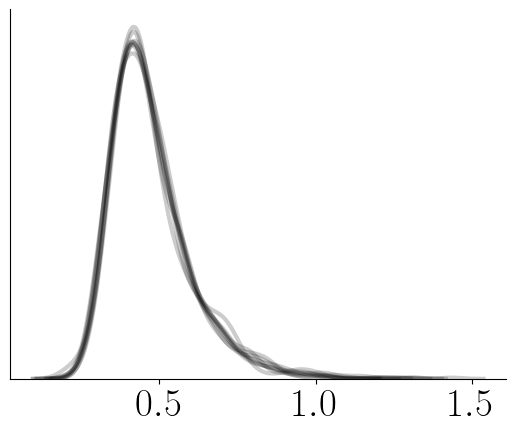

In [8]:
A=Araw[~np.isnan(Araw.sum(axis=1)),:]
means_expt = []
sem_expt = []
red = np.array([1,0,0])
blue = np.array([0,0,1])
X = []
for i,a in enumerate(A):
    x = np.histogram(a,bins=15,density=True,range=(np.min(A),np.max(A)))
    X.append(x[0]/(sum(x[0])*(x[1][1]-x[1][0])))
    sns.kdeplot(a,c='k',lw=3,alpha=0.2)
    means_expt.append(a.mean())
    sem_expt.append(stats.sem(a))
plt.ylabel('')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks([])
plt.show()

## d

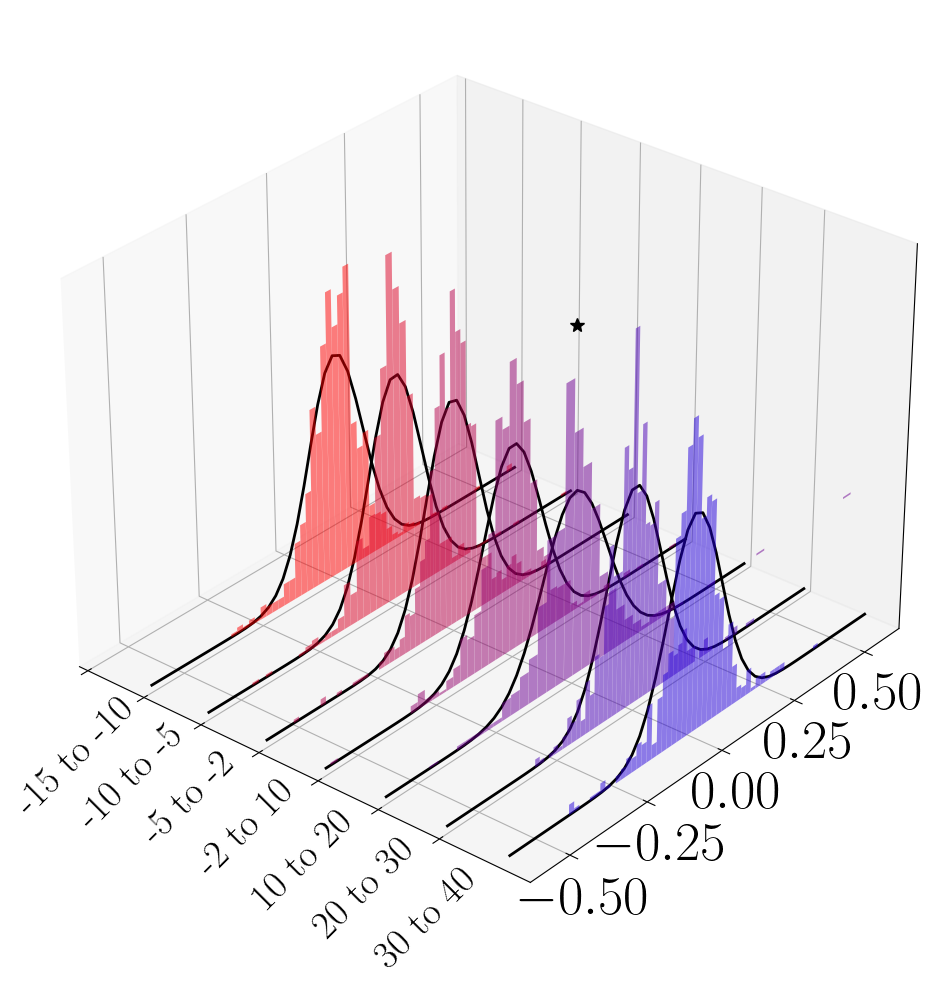

In [5]:
col ='k'
A = Araw.T[~np.isnan(Araw.T.sum(axis=1)),:].T
Del = []
for i in range(7):
    Del.append(A[i+1]-A[i])
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
nbins = 50
red = np.array([1,0,0])
blue = np.array([0,0,1])
for i,(z,d) in enumerate(zip([120,100,80,60, 40, 20, 0][::-1],Del)):
    hist, bins = np.histogram(d, bins=nbins,density=True)
    xs = (bins[:-1] + bins[1:])/2

    ax.bar(xs, hist, zs=z, zdir='x', 
           color=i/7*blue + (7-i)/7*red,alpha=0.5,width=(xs[-1]-xs[0])/nbins)
    mu, std = stats.norm.fit(d)
    x = np.linspace(-0.6,0.6)
    p = stats.norm.pdf(x, mu, std)
    ax.plot(x,p,zs=z, zdir='x', linewidth=2,c='k')
    if(i==4):
        plt.plot(z,mu,max(hist)+1.0,'*',c='k',ms=10)
ax.view_init(elev=30., azim=-50)
ax.set_ylim(-0.6,0.6)
ax.set_xticks([-20,0,20,40,60,80,100],[r'-15 to -10',r'-10 to -5',r'-5 to -2',
                                      r'-2 to 10',r'10 to 20',r'20 to 30',
                                      r'30 to 40'],rotation=45)
ax.set_zticks([])
ax.yaxis.labelpad = 10
ax.tick_params(axis='y', labelsize=40)

# Supplemental figure 2

Text(0.5, 0, 'Spine size change ($\\mu m^2$)')

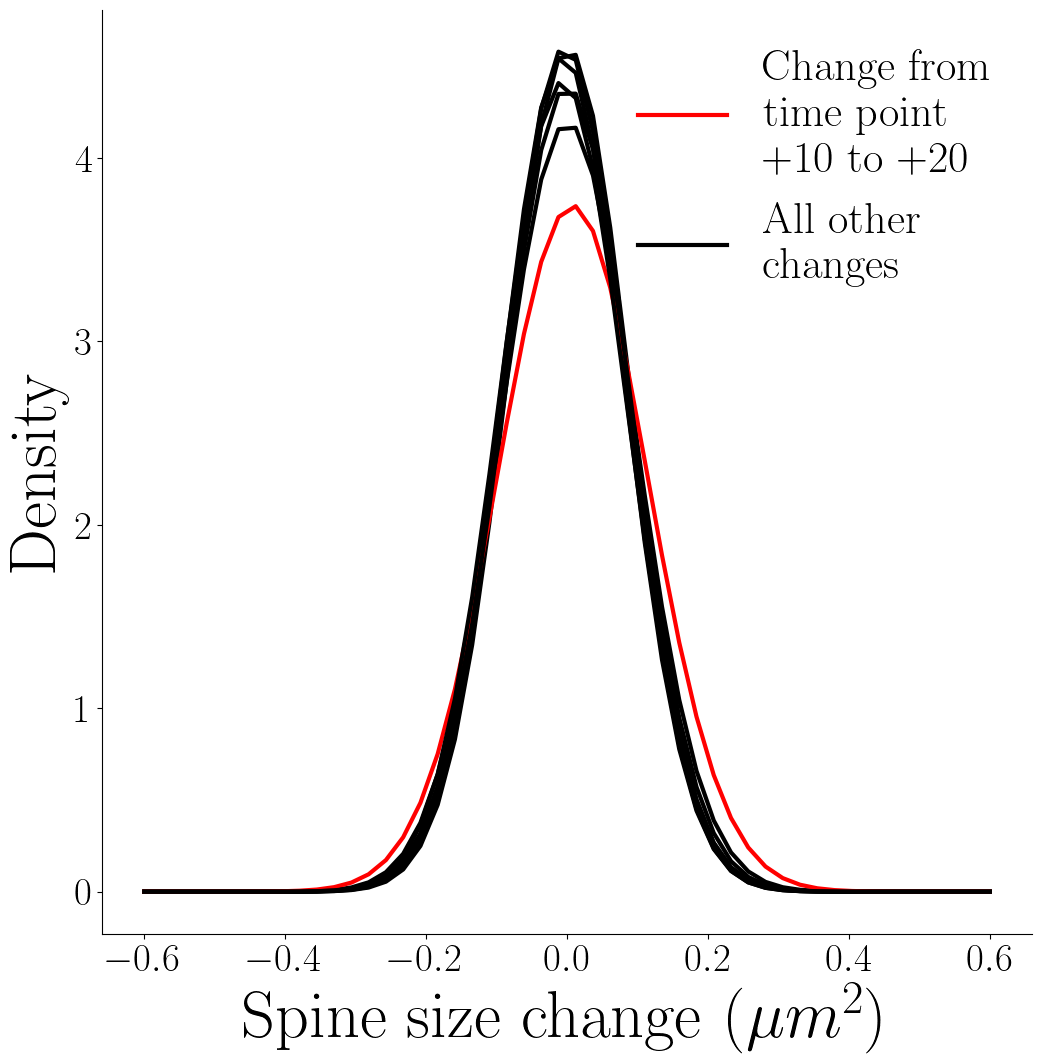

In [16]:
fig,ax = plt.subplots(figsize=(12,12))
col ='k'
A = Araw.T[~np.isnan(Araw.T.sum(axis=1)),:].T
Del = []
for i in range(7):
    Del.append(A[i+1]-A[i])

nbins = 50
red = np.array([1,0,0])
blue = np.array([0,0,1])
for i,(z,d) in enumerate(zip([120,100,80,60, 40, 20, 0],Del)):
    mu, std = stats.norm.fit(d)
    x = np.linspace(-0.6,0.6)
    p = stats.norm.pdf(x, mu, std)
    if(i==4):
        ax.plot(x,p, linewidth=3,c='r',label='Change from \n time point \n +10 to +20')
    elif(i<6):
        ax.plot(x,p, linewidth=3,c='k')
    else:
        ax.plot(x,p, linewidth=3,c='k',label='All other \n changes')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

leg = plt.legend(fontsize=32)
leg.get_frame().set_linewidth(0.0)
plt.ylabel('Density',fontsize=48)
plt.xlabel(r'Spine size change ($\mu m^2$)',fontsize=48)

# Supplemental figure 3

## i

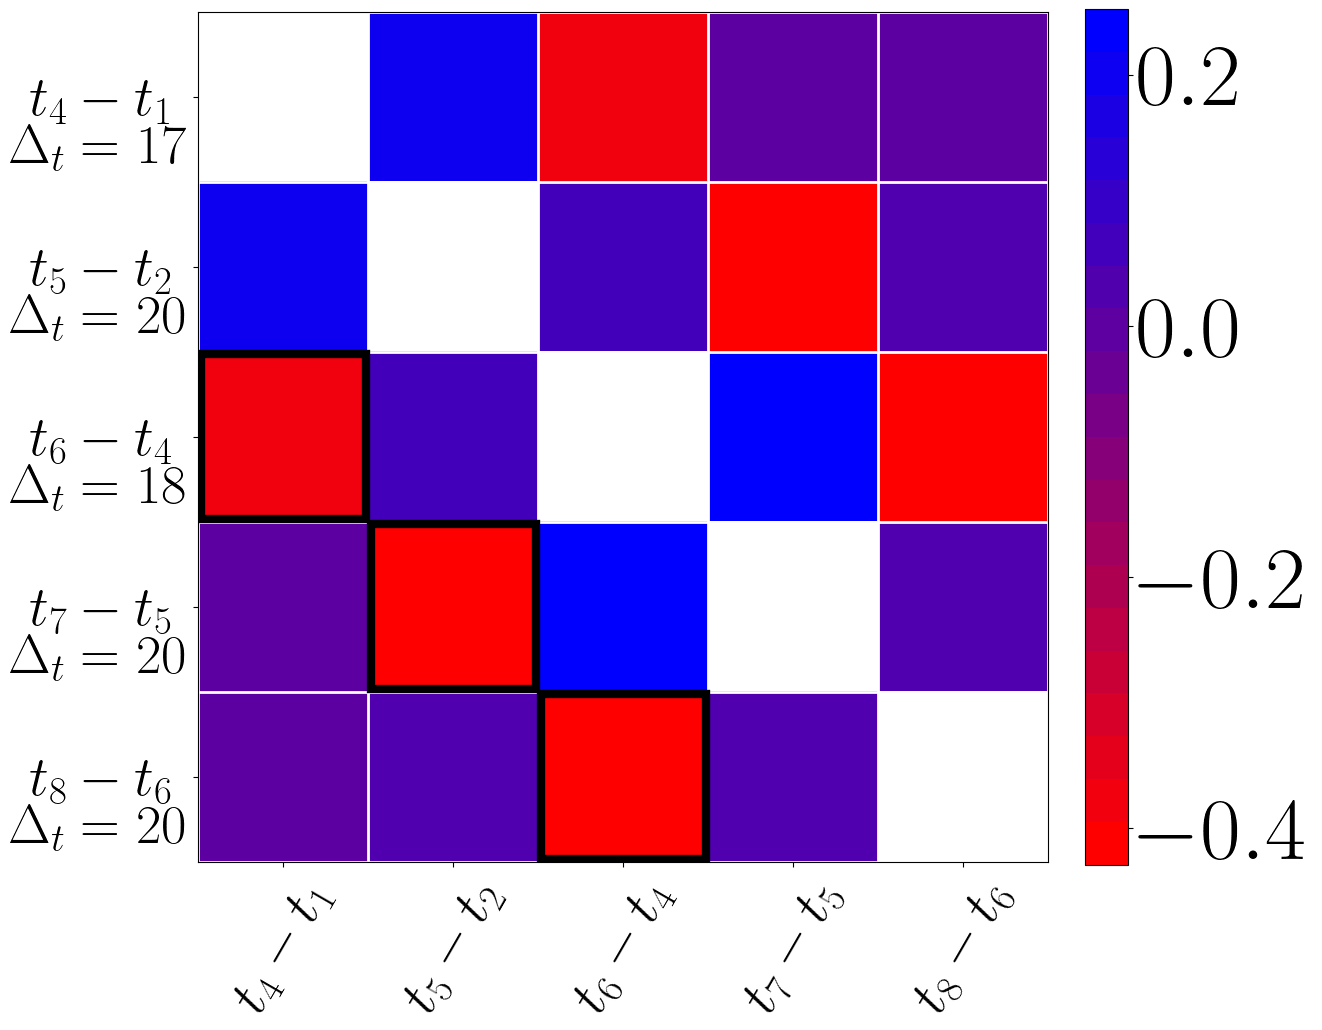

In [13]:
label = [r'$t_4-t_1$ \\ $\Delta_t = 17$',r'$t_5-t_2$ \\ $\Delta_t = 20$',
        r'$t_6-t_4$ \\ $\Delta_t = 18$',r'$t_7-t_5$ \\ $\Delta_t = 20$',
        r'$t_8-t_6$ \\ $\Delta_t = 20$']
label2 = [r'$t_4-t_1$',r'$t_5-t_2$',
        r'$t_6-t_4$',r'$t_7-t_5$',
        r'$t_8-t_6$']
colors = [(1.0,0.0, 0.0),(0,0,1)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
A = Araw#.T
ArawD = [A[3]-A[0],A[4]-A[1],A[5]-A[3],A[6]-A[4],A[7]-A[5]]
CorrMat = np.zeros((5,5))
for i,a1 in enumerate(ArawD):
    for j,a2 in enumerate(ArawD):
        CorrMat[i,j] = np.corrcoef(a1[~np.logical_or(np.isnan(a1),np.isnan(a2))],a2[~np.logical_or(np.isnan(a1),np.isnan(a2))])[1,0]

for i in range(5):
    CorrMat[i,i] = math.nan
fig,ax = plt.subplots(figsize=(12,12))
g = ax.imshow(CorrMat,cmap=cm)
cbar = plt.colorbar(g,fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=64)
plt.yticks([0,1,2,3,4],label,fontsize=40)
plt.xticks([0,1,2,3,4],label2,fontsize=40,rotation=60)
ax = plt.gca()
# Minor ticks
ax.set_xticks(np.arange(-.5, 5, 1), minor=True)
ax.set_yticks(np.arange(-.5, 5, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)

x = 2.015
y = 4.015
width = 0.97
height = 0.97

# Create a rectangle patch
rect = patches.Rectangle((x-0.5, y-0.5), width, height, linewidth=6, edgecolor='k', facecolor='none',zorder=3)

# Add the rectangle patch to the plot
ax.add_patch(rect)

x = 1.015
y = 3.015
width = 0.97
height = 0.97

# Create a rectangle patch
rect = patches.Rectangle((x-0.5, y-0.5), width, height, linewidth=6, edgecolor='k', facecolor='none',zorder=3)

# Add the rectangle patch to the plot
ax.add_patch(rect)

x = 0.015
y = 2.015
width = 0.97
height = 0.97

# Create a rectangle patch
rect = patches.Rectangle((x-0.5, y-0.5), width, height, linewidth=6, edgecolor='k', facecolor='none',zorder=3)

# Add the rectangle patch to the plot
ax.add_patch(rect)

plt.show()

# Supplemental figure 5

## a

[]

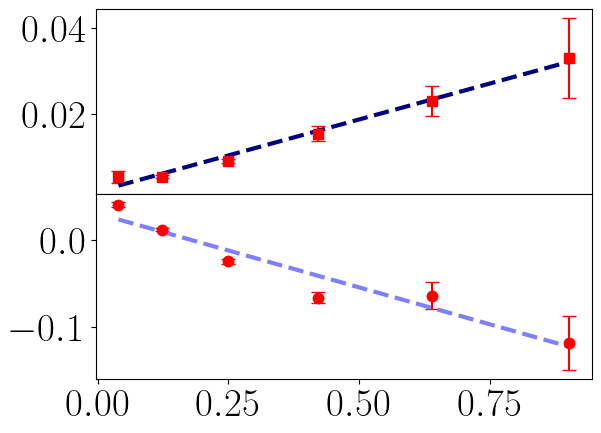

In [18]:
fig,ax = plt.subplots(2,1)
plt.subplots_adjust(wspace=0, hspace=0)
lowermean = []
lowerstd  = []
uppermean = []
upperstd  = []
semMean = []
semSTD  = []
for Cutoff in np.arange(0.2,1.0,0.15):
    col ='k'
    A = Araw
    Del1 = []
    for i in range(7):
        mask = np.logical_and(A[i]>Cutoff,A[i]<Cutoff+0.15)
        Del1.append(A[i+1,mask]-A[i,mask])
    DelF = np.hstack(Del1).flatten()
    DelF = np.hstack(Del1).flatten()
    mu, std = stats.norm.fit(DelF)
    std = std**2
    mu = mu
    semMean.append(stats.bootstrap((DelF,), np.mean, confidence_level=0.95,
                         random_state=1, method='percentile').standard_error)
    semSTD.append(stats.bootstrap((DelF,), np.var, confidence_level=0.95,
                     random_state=1, method='percentile').standard_error)
    lowermean.append(mu)
    lowerstd.append(std)
ml = stats.linregress(np.arange(0.2,1.0,0.15)**2,lowermean)
sl = stats.linregress(np.arange(0.2,1.0,0.15)**2,lowerstd)
ax[1].errorbar(np.arange(0.2,1.0,0.15)**2,lowermean,semMean,capsize=5,ls='None',ms=15,fmt='.',color='r')
ax[1].plot(np.arange(0.2,1.0,0.15)**2,(np.arange(0.2,1.0,0.15)**2)*ml.slope+ml.intercept,ls='--',c=blue+[0.5,0.5,0],lw=3,label='Best fit LN Model')
ax[0].errorbar(np.arange(0.2,1.0,0.15)**2,lowerstd,semSTD,capsize=5,ls='None',ms=7,fmt='s',color='r')
ax[0].plot(np.arange(0.2,1.0,0.15)**2,(np.arange(0.2,1.0,0.15)**2)*sl.slope+sl.intercept,ls='--',c=blue*0.5,lw=3)
ax[0].set_xticks([])

## b

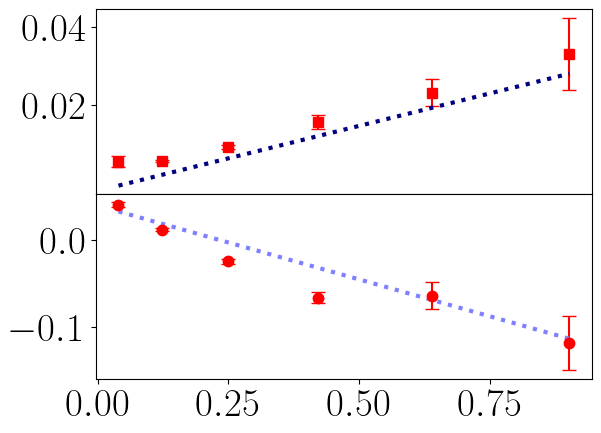

In [21]:
fig,ax = plt.subplots(2,1)
plt.subplots_adjust(wspace=0, hspace=0)
lowermean = []
lowerstd  = []
uppermean = []
upperstd  = []
semMean = []
semSTD  = []
for Cutoff in np.arange(0.2,1.0,0.15):
    col ='k'
    A = Araw
    Del1 = []
    for i in range(7):
        mask = np.logical_and(A[i]>Cutoff,A[i]<Cutoff+0.15)
        Del1.append(A[i+1,mask]-A[i,mask])
    DelF = np.hstack(Del1).flatten()
    DelF = np.hstack(Del1).flatten()
    mu, std = stats.norm.fit(DelF)
    std = std**2
    mu = mu
    semMean.append(stats.bootstrap((DelF,), np.mean, confidence_level=0.95,
                         random_state=1, method='percentile').standard_error)
    semSTD.append(stats.bootstrap((DelF,), np.var, confidence_level=0.95,
                     random_state=1, method='percentile').standard_error)
    lowermean.append(mu)
    lowerstd.append(std)
ml = stats.linregress(np.arange(0.2,1.0,0.15)**2,lowermean)
sl = stats.linregress(np.arange(0.2,1.0,0.15)**2,lowerstd)
ax[1].errorbar(np.arange(0.2,1.0,0.15)**2,lowermean,semMean,capsize=5,ls='None',ms=15,fmt='.',color='r')
ax[1].plot(np.arange(0.2,1.0,0.15)**2,(np.arange(0.2,1.0,0.15)**2)*ml.slope+1.3*ml.intercept,ls=':',c=blue+[0.5,0.5,0],lw=3,label='Best fit LN Model')
ax[0].errorbar(np.arange(0.2,1.0,0.15)**2,lowerstd,semSTD,capsize=5,ls='None',ms=7,fmt='s',color='r')
ax[0].plot(np.arange(0.2,1.0,0.15)**2,(np.arange(0.2,1.0,0.15)**2)*sl.slope-sl.intercept,ls=':',c=blue*0.5,lw=3)
ax[0].set_xticks([])
ax[0].set_yticks([0.02,0.04])

## c

In [22]:
def ContLN():
    fmean = sp.interpolate.interp1d(np.arange(0,5.0,0.15)**2,(np.arange(0,5.0,0.15)**2)*ml.slope+ml.intercept)
    fstd = sp.interpolate.interp1d(np.arange(0,5.0,0.15)**2,(np.arange(0,5.0,0.15)**2)*sl.slope+sl.intercept)


    S = [Araw[0]]
    for i in range(1,8):
        sMean = fmean(S[-1]**2)+1
        sStd  = np.sqrt(fstd(S[-1]**2))
        lmean = np.log(((sMean)**2)/np.sqrt(sStd**2+(sMean)**2))
        lsig = np.sqrt(np.log((sStd/(sMean))**2 + 1))
        yi = np.random.lognormal(lmean,lsig)
        S.append(S[-1]+yi-1)
    return np.array(S)

def ContLN2():
    fmean = sp.interpolate.interp1d(np.arange(0,5.0,0.15)**2,(np.arange(0,5.0,0.15)**2)*ml.slope+1.3*ml.intercept)
    fstd = sp.interpolate.interp1d(np.arange(0,5.0,0.15)**2,(np.arange(0,5.0,0.15)**2)*sl.slope-sl.intercept)


    S = [Araw[0]]
    for i in range(1,8):
        sMean = fmean(S[-1]**2)+1
        sStd  = np.sqrt(np.clip(fstd(S[-1]**2),0,np.infty))
        lmean = np.log(((sMean)**2)/np.sqrt(sStd**2+(sMean)**2))
        lsig = np.sqrt(np.log((sStd/(sMean))**2 + 1))
        yi = np.random.lognormal(lmean,lsig)
        S.append(S[-1]+yi-1)
    return np.array(S)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1355.12it/s]


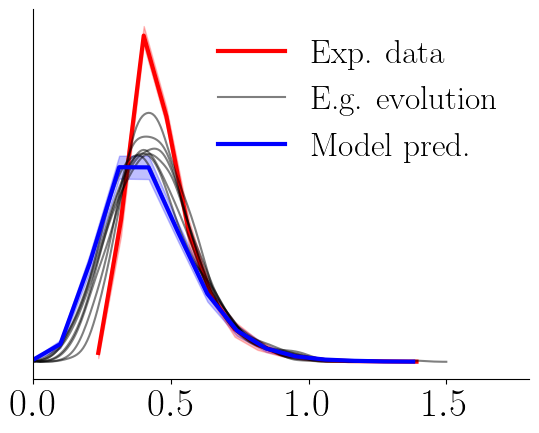

In [25]:
S_MC = []
for k in tqdm.tqdm(range(1000)):
    S_MC.append(ContLN())
S_MC = np.array(S_MC)
X1 = [] 
X2 = []
for i,s in enumerate(S_MC[:,-1,:]):
    x = np.histogram(s,bins=15,density=True,range=(np.nanmin(S_MC), np.nanmax(Araw)))
    X1.append(x[0]/(sum(x[0])*(x[1][1]-x[1][0])))
    X2.append((x[1][:-1]+x[1][1:])/2)
X1 = np.array(X1)
X2 = np.array(X2)
S1 = [] 
S2 = []
for a in Araw:
    x = np.histogram(a,bins=15,density=True,range=(np.nanmin(Araw), np.nanmax(Araw)))
    S1.append(x[0]/(sum(x[0])*(x[1][1]-x[1][0])))
    S2.append((x[1][:-1]+x[1][1:])/2)
S1 = np.array(S1)
S2 = np.array(S2)
plt.fill_between(X2[0], X1.mean(axis=0)-X1.std(axis=0), X1.mean(axis=0)+X1.std(axis=0),
                 color='b',alpha=0.25)
plt.plot(S2[0], S1.mean(axis=0), 'r-',lw=3,label='Exp. data')

plt.fill_between(S2[0], S1.mean(axis=0)-S1.std(axis=0), S1.mean(axis=0)+S1.std(axis=0),
                 color='r',alpha=0.25)

for i,s in enumerate(S_MC[0,1:,:]):
    if(i==0):
        sns.kdeplot(s,c='k',alpha=0.5,
                label='E.g. evolution')
    else:
        sns.kdeplot(s,c='k',alpha=0.5)
plt.plot(X2[0], X1.mean(axis=0), 'b-',lw=3,label='Model pred.')
leg = plt.legend(fontsize=24)
leg.get_frame().set_linewidth(0.0)
plt.yticks([])
plt.xlim([0,1.8])
plt.ylabel('')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

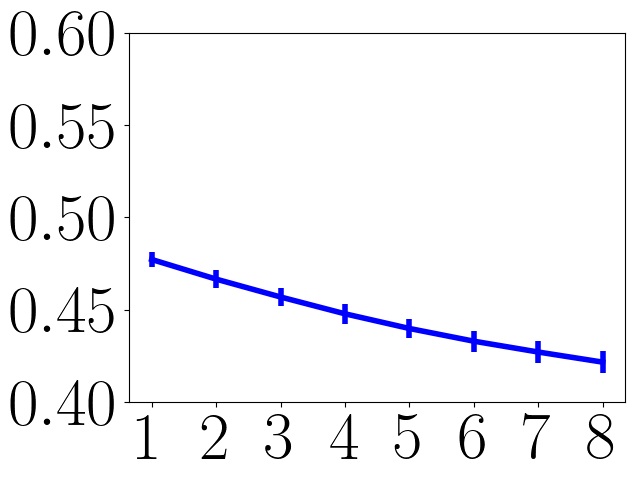

In [27]:
plt.plot(np.mean(S_MC.mean(axis=-1),axis=0))
plt.errorbar(x = np.arange(8),y = np.mean(S_MC.mean(axis=-1),axis=0), 
             yerr=sp.stats.sem(S_MC[0],axis=1) ,lw=4,c='b')
plt.ylim([0.4,0.6])
plt.yticks(fontsize=48)
plt.xticks([0,1,2,3,4,5,6,7],[1,2,3,4,5,6,7,8],fontsize=48)
plt.show()

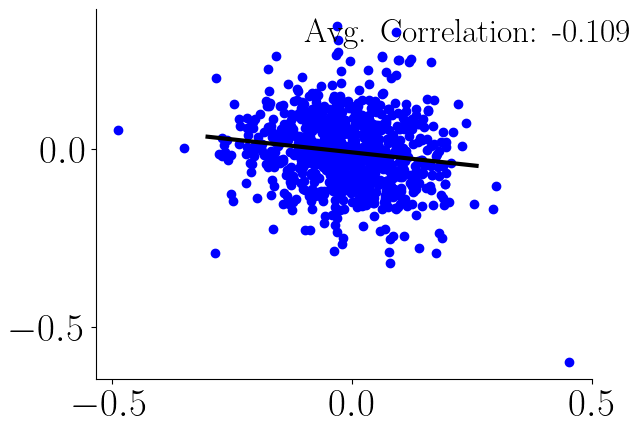

In [28]:
A1 = np.roll(S_MC,-1,axis=-2)[:,:-2,:]-S_MC[:,:-2,:]
A2 = np.roll(S_MC,-2,axis=-2)[:,:-2,:]-np.roll(S_MC,-1,axis=-2)[:,:-2,:]
A1 = np.swapaxes(A1,-2,-1)
A2 = np.swapaxes(A2,-2,-1)
Corr = []
for a1,a2 in zip(A1,A2):
    for i in range(6):
        Corr.append(np.corrcoef(a1[:,i],a2[:,i])[1,0])

a1 = A1[0,np.logical_and(A1[0,:,0]!=0,A2[0,:,0]!=0),0]
a2 = A2[0,np.logical_and(A1[0,:,0]!=0,A2[0,:,0]!=0),0]
plt.scatter(A1[0,np.logical_and(A1[0,:,0]!=0,A2[0,:,0]!=0),0],
            A2[0,np.logical_and(A1[0,:,0]!=0,A2[0,:,0]!=0),0],c='b')
slope, intercept, r_value, p_value, std_err = stats.linregress(a1,a2)
amin = -0.3
amax = 0.26
plt.plot(np.arange(amin,amax,0.01),np.arange(amin,amax,0.01)*slope+intercept,'k',lw=3)

#x = np.corrcoef(A1,A2)
plt.text(x=-0.1,y=0.3,s="Avg. Correlation: {:0.3}".format(np.mean(Corr)),fontsize=24)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## e

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1329.20it/s]


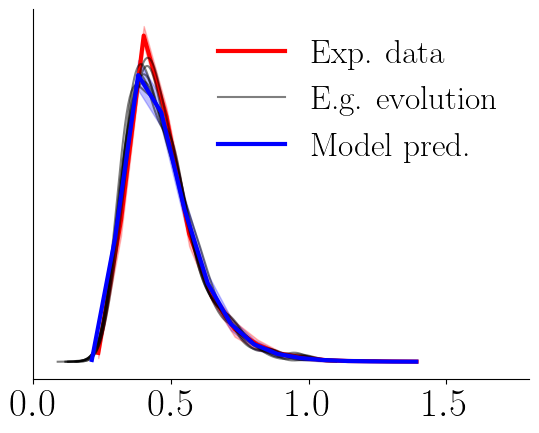

In [29]:
S_MC = []
for k in tqdm.tqdm(range(1000)):
    S_MC.append(ContLN2())
S_MC = np.array(S_MC)
X1 = [] 
X2 = []
for i,s in enumerate(S_MC[:,-1,:]):
    x = np.histogram(s,bins=15,density=True,range=(np.nanmin(S_MC), np.nanmax(Araw)))
    X1.append(x[0]/(sum(x[0])*(x[1][1]-x[1][0])))
    X2.append((x[1][:-1]+x[1][1:])/2)
X1 = np.array(X1)
X2 = np.array(X2)
S1 = [] 
S2 = []
for a in Araw:
    x = np.histogram(a,bins=15,density=True,range=(np.nanmin(Araw), np.nanmax(Araw)))
    S1.append(x[0]/(sum(x[0])*(x[1][1]-x[1][0])))
    S2.append((x[1][:-1]+x[1][1:])/2)
S1 = np.array(S1)
S2 = np.array(S2)
plt.fill_between(X2[0], X1.mean(axis=0)-X1.std(axis=0), X1.mean(axis=0)+X1.std(axis=0),
                 color='b',alpha=0.25)
plt.plot(S2[0], S1.mean(axis=0), 'r-',lw=3,label='Exp. data')

plt.fill_between(S2[0], S1.mean(axis=0)-S1.std(axis=0), S1.mean(axis=0)+S1.std(axis=0),
                 color='r',alpha=0.25)

for i,s in enumerate(S_MC[0,1:,:]):
    if(i==0):
        sns.kdeplot(s,c='k',alpha=0.5,
                label='E.g. evolution')
    else:
        sns.kdeplot(s,c='k',alpha=0.5)
plt.plot(X2[0], X1.mean(axis=0), 'b-',lw=3,label='Model pred.')
leg = plt.legend(fontsize=24)
leg.get_frame().set_linewidth(0.0)
plt.yticks([])
plt.xlim([0,1.8])
plt.ylabel('')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

([<matplotlib.axis.XTick at 0x15b84c700>,
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8')])

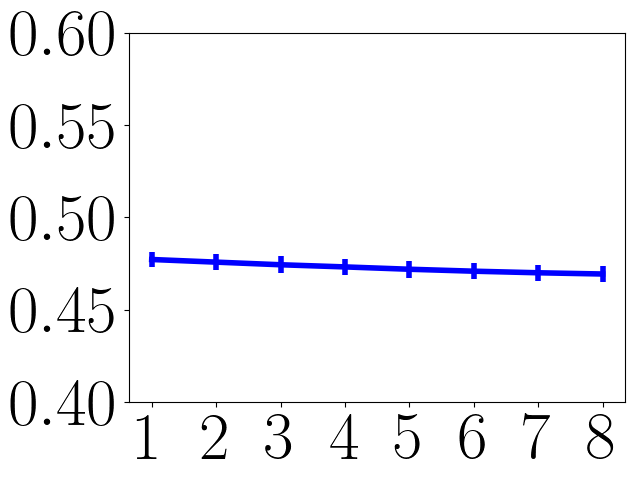

In [30]:
plt.plot(np.mean(np.nanmean(S_MC,axis=-1),axis=0))
plt.errorbar(x = np.arange(8),y = np.mean(np.nanmean(S_MC,axis=-1),axis=0), 
             yerr=sp.stats.sem(S_MC[0],axis=1) ,lw=4,c='b')
plt.ylim([0.4,0.6])
plt.yticks(fontsize=48)
plt.xticks([0,1,2,3,4,5,6,7],[1,2,3,4,5,6,7,8],fontsize=48)

In [ ]:
## f

A1 = np.roll(S_MC,-1,axis=-2)[:,:-2,:]-S_MC[:,:-2,:]
A2 = np.roll(S_MC,-2,axis=-2)[:,:-2,:]-np.roll(S_MC,-1,axis=-2)[:,:-2,:]
A1 = np.swapaxes(A1,-2,-1)
A2 = np.swapaxes(A2,-2,-1)
Corr = []
for a1,a2 in zip(A1,A2):
    for i in range(6):
        Corr.append(np.corrcoef(a1[:,i],a2[:,i])[1,0])

a1 = A1[0,np.logical_and(A1[0,:,0]!=0,A2[0,:,0]!=0),0]
a2 = A2[0,np.logical_and(A1[0,:,0]!=0,A2[0,:,0]!=0),0]
plt.scatter(A1[0,np.logical_and(A1[0,:,0]!=0,A2[0,:,0]!=0),0],
            A2[0,np.logical_and(A1[0,:,0]!=0,A2[0,:,0]!=0),0],c='b')
slope, intercept, r_value, p_value, std_err = stats.linregress(a1,a2)
amin = -0.3
amax = 0.26
plt.plot(np.arange(amin,amax,0.01),np.arange(amin,amax,0.01)*slope+intercept,'k',lw=3)

#x = np.corrcoef(A1,A2)
plt.text(x=-0.1,y=0.3,s="Avg. Correlation: {:0.3}".format(np.mean(Corr)),fontsize=24)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)